# Single Band Data Compression

In [1]:
# imports 
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags, hstack as sparse_hstack
import os
from skimage.transform import resize
import pandas as pd
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import imageio
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize
from matplotlib.colorbar import Colorbar
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import cm
import pytz
from pytz import timezone

## Helper Functions

In [2]:
#Function to load in the data
def load_nc_timeseries(filepath):
    ds = xr.open_dataset(filepath)
    data = ds['Rad'].values 

    time_raw = ds['time'].values
    times = pd.to_datetime(time_raw).to_pydatetime().tolist()

    return data, times

# Function to interpolate and trim frames, making sure frames are equally aligned
def interpolate_and_trim_frames(frames, times, duration, frame_spacing=timedelta(minutes=10),  max_gap=timedelta(minutes=12)):
    max_frames = int(duration / frame_spacing)
    expected_spacing = duration / max_frames

    cleaned_frames = []
    cleaned_times = []

    current_block = []
    current_times = []
    start_time = times[0]

    for frame, t in zip(frames, times):
        if t - start_time < duration:
            current_block.append(frame)
            current_times.append(t)
        else:
            # Process current block
            if len(current_block) > 0:
                # Interpolate gaps
                new_frames = list(current_block)
                new_times = list(current_times)
                total_insertions = 0
                MAX_INSERTIONS = 50

                made_change = True
                while made_change:
                    made_change = False
                    i = 0
                    while i < len(new_times) - 1:
                        gap = new_times[i + 1] - new_times[i]
                        if gap > timedelta(hours=2):
                            print(f"Large time gap: {gap} at index {i}")
                            num_insertions = int(round(gap / frame_spacing)) - 1
                        elif gap > max_gap:
                            num_insertions = int(round(gap / expected_spacing)) - 1
                        else:
                            num_insertions = 0
                            
                        if num_insertions > 0:
                            for n in range(1, num_insertions + 1):
                                alpha = n / (num_insertions + 1)
                                interp_time = new_times[i] + alpha * gap
                                interp_frame = (1 - alpha) * new_frames[i] + alpha * new_frames[i + 1]
                                new_times.insert(i + n, interp_time)
                                new_frames.insert(i + n, interp_frame)
                                total_insertions += 1

                                if total_insertions > MAX_INSERTIONS: 
                                    print("Too many interpolated frames — skipping block early.")
                                    return np.array([]), []

                            made_change = True
                            i += num_insertions
                        i += 1

                #Trim block to fit duration and frame count
                trimmed_frames = [new_frames[0]]
                trimmed_times = [new_times[0]]
                block_start_time = new_times[0]

                for i in range(1, len(new_times)):
                    if new_times[i] - block_start_time > duration:
                        break
                    trimmed_frames.append(new_frames[i])
                    trimmed_times.append(new_times[i])
                    if len(trimmed_frames) >= max_frames:
                        break

                cleaned_frames.extend(trimmed_frames)
                cleaned_times.extend(trimmed_times)

            # Start new block
            current_block = [frame]
            current_times = [t]
            start_time = t

    # Process final block
    if len(current_block) > 0:
        new_frames = list(current_block)
        new_times = list(current_times)

        made_change = True
        while made_change:
            made_change = False
            i = 0
            while i < len(new_times) - 1:
                gap = new_times[i + 1] - new_times[i]
                if gap > max_gap:
                    num_insertions = int(round(gap / expected_spacing)) - 1
                    for n in range(1, num_insertions + 1):
                        alpha = n / (num_insertions + 1)
                        interp_time = new_times[i] + alpha * gap
                        interp_frame = (1 - alpha) * new_frames[i] + alpha * new_frames[i + 1]
                        new_times.insert(i + n, interp_time)
                        new_frames.insert(i + n, interp_frame)
                    made_change = True
                    i += num_insertions
                i += 1

        trimmed_frames = [new_frames[0]]
        trimmed_times = [new_times[0]]
        block_start_time = new_times[0]

        for i in range(1, len(new_times)):
            if new_times[i] - block_start_time > duration:
                break
            trimmed_frames.append(new_frames[i])
            trimmed_times.append(new_times[i])
            if len(trimmed_frames) >= max_frames:
                break

        cleaned_frames.extend(trimmed_frames)
        cleaned_times.extend(trimmed_times)

    return np.array(cleaned_frames), cleaned_times


In [3]:
#Temporal Compression Function based off of Zhang et al., 2025
def compress_frames_by_time(frames, times, duration: timedelta, p=0.5, noise_std=0.001):
    T, H, W = frames.shape
    blocks = []
    all_masks = []
    compressed = []

    y_list = []
    phi_list = []
    x_list = []
    g_list = []
    forward_compressed_frame_list = []
    block_times = []

    start_idx = 0
    with tqdm(desc="Compressing Time-Based Blocks") as pbar: #Run through blocks
        while start_idx < T:
            start_time = times[start_idx]
            end_idx = start_idx
            while end_idx < T and (times[end_idx] - start_time) < duration:
                end_idx += 1

            block = frames[start_idx:end_idx]
            
            if len(block) == 0:
                break
            print(f"Compressing block {len(blocks)} with {block.shape[0]} frames") 
            block_times.append(start_time + (duration/2))

            current_block_size = block.shape[0]

            # Generate masks
            masks = np.random.binomial(n=1, p=p, size=(current_block_size, H, W))

            unsampled_mask = np.sum(masks, axis=0) == 0
            if np.any(unsampled_mask):
                unsampled_indices = np.argwhere(unsampled_mask)
                for h, w in unsampled_indices:
                    t_idx = np.random.randint(0, current_block_size)
                    masks[t_idx, h, w] = 1

            #Force center pixel to be sampled at least once (important check for plotting purposes)
            if np.sum(masks[:, H//2, W//2]) == 0:
                idx = np.random.randint(0, current_block_size)
                masks[idx, H//2, W//2] = 1

            #Apply the masks 
            masked_sum = np.nansum(block * masks, axis=0)

            # Forward model: y = phi x + g
            x = np.concatenate([frame.flatten() for frame in block])
            diagonal_masks = [diags(mask.flatten(), 0, format='csr') for mask in masks]
            phi = sparse_hstack(diagonal_masks).tocsr()
            g = 0  # you can add noise here if you want
            y = phi @ x + g
            flattened_mask_sum = np.sum(masks, axis=0).flatten()
            forward_compressed_frame = (y / np.maximum(flattened_mask_sum, 1e-8)).reshape(H, W)

            # Save forward model components
            y_list.append(y)
            phi_list.append(phi)
            x_list.append(x)
            g_list.append(g)
            forward_compressed_frame_list.append(forward_compressed_frame)
            blocks.append(block)

            # Final output with safety division
            compressed_frame = masked_sum / np.maximum(np.sum(masks, axis=0), 1e-8)
            mask_sum = np.sum(masks, axis=0)
            compressed_frame[mask_sum == 0] = np.nan


            compressed.append(compressed_frame)
            all_masks.append(masks)

            pbar.update(current_block_size)
            start_idx = end_idx

        # Adjust block times to match output length if needed
        num_blocks = len(compressed)
        merged_block_times = [times[0] + i * duration for i in range(num_blocks)]

    return compressed, blocks, all_masks, y_list, phi_list, x_list, g_list, forward_compressed_frame_list, block_times, merged_block_times


# Plotting Functions

In [4]:
#visualize an entire compressed frame 
def plot_compression(frames, masks, compressed_frame, cmap = 'plasma'):
    N, H, W = frames.shape
    vmin = np.nanmin(frames)
    vmax = np.nanmax(frames)
    
    fig, axs = plt.subplots(N, 3, figsize = (10, 2.5 * N))

    vmin = np.nanmin(frames)
    vmax = np.nanmax(frames)

    for i in range(N):
        im = axs[i,0].imshow(frames[i], cmap = cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(im, ax=axs[i, 0], fraction=0.046, pad=0.04, label='Radiance')
        axs[i,0].set_title(f'Original Frame {i+1}')
        axs[i,0].axis('off')

        im = axs[i,1].imshow(masks[i], cmap='gray')
        fig.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)
        axs[i,1].set_title(f'Mask {i+1}')
        axs[i,1].axis('off')

        im = axs[i,2].imshow(frames[i] * masks[i], cmap='plasma',vmin=vmin, vmax=vmax)
        fig.colorbar(im, ax=axs[i, 2], fraction=0.046, pad=0.04, label='Radiance')
        axs[i,2].set_title(f'Masked Frame')
        axs[i,2].axis('off')

    plt.show()

    vmin = np.min(frames)
    vmax = np.max(frames)

    visual_frame = compressed_frame.copy()
    visual_frame[np.sum(masks, axis=0) == 0] = np.nan


    plt.figure(figsize = (4,4))
    im  = plt.imshow(visual_frame, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title('Compressed Frame (Normalized)')
    plt.colorbar(im, fraction=0.046, pad=0.04, label = 'Radiance')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [5]:
# #Time series plotter, old vs new time series. 
def plot_center_pixel_time_series(frames, compressed_frames, masks, times_compressed, times_original):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    T, H, W = frames.shape
    center_row = H // 2
    center_col = W // 2

    compressed_f = np.array(compressed_frames)
    original_ts = frames[:, center_row, center_col]
    compressed_ts_raw = compressed_f[:, center_row, center_col]

    expected_blocks = min(len(compressed_f), len(masks))
    compressed_f = compressed_f[:expected_blocks]
    masks = masks[:expected_blocks]
    times_compressed = times_compressed[:expected_blocks]

    # Convert times
    original_times = pd.to_datetime(times_original)
    compressed_times = pd.to_datetime(times_compressed)

    # Mask sum at center
    mask_sums = np.array([np.sum(mask[:, center_row, center_col]) for mask in masks])
    compressed_ts = np.full(expected_blocks, np.nan, dtype=np.float64)
    valid_mask = mask_sums > 0
    compressed_ts[valid_mask] = compressed_ts_raw[valid_mask]

    # Separate valid and invalid masks
    compressed_valid = valid_mask
    compressed_invalid = ~valid_mask

    print(f"Compressed blocks: {expected_blocks}")
    if np.any(compressed_invalid):
        print("Blocks with zero center mask coverage that need to be fixed:")
        for i in np.where(compressed_invalid)[0]:
            print(f"  Block {i}: {compressed_times[i]}")

    #Original and Compressed Time Series
    plt.figure(figsize=(12, 5))
    plt.plot(original_times, original_ts, label='Original Time Series', color='gray', alpha=0.4, marker='')
    plt.plot(compressed_times[compressed_valid], compressed_ts[compressed_valid], 
             label='Compressed Time Series', color='purple', marker='')
    plt.title("Time Series at Observed Center")
    plt.xlabel("Time")
    plt.ylabel("Radiance")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

⚠️ Large time gap: 3:00:00 at index 2


Compressing Time-Based Blocks: 432it [00:00, 4156.28it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames


Compressing Time-Based Blocks: 1440it [00:00, 4448.27it/s]

Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames


Compressing Time-Based Blocks: 2448it [00:00, 4548.16it/s]

Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames


Compressing Time-Based Blocks: 3456it [00:00, 4550.26it/s]

Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames


Compressing Time-Based Blocks: 3960it [00:00, 4425.71it/s]

Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames


Compressing Time-Based Blocks: 4464it [00:01, 4250.82it/s]

Compressing block 61 with 72 frames
Compressing block 62 with 72 frames


Compressing Time-Based Blocks: 4968it [00:01, 4335.47it/s]

Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 72 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames


Compressing Time-Based Blocks: 5976it [00:01, 4496.24it/s]

Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames


Compressing Time-Based Blocks: 6984it [00:01, 4573.75it/s]

Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames


Compressing Time-Based Blocks: 7992it [00:01, 4573.49it/s]

Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames


Compressing Time-Based Blocks: 9000it [00:02, 4611.59it/s]

Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames


Compressing Time-Based Blocks: 9504it [00:02, 4547.53it/s]

Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames


Compressing Time-Based Blocks: 10008it [00:02, 4129.46it/s]

Compressing block 139 with 72 frames


Compressing Time-Based Blocks: 10512it [00:02, 4277.95it/s]

Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 72 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames


Compressing Time-Based Blocks: 11016it [00:02, 4413.07it/s]

Compressing block 153 with 72 frames


Compressing Time-Based Blocks: 11520it [00:02, 4448.68it/s]

Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames


Compressing Time-Based Blocks: 12528it [00:02, 4176.52it/s]

Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames


Compressing Time-Based Blocks: 13536it [00:03, 4402.25it/s]

Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 72 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 72 frames
Compressing block 192 with 72 frames


Compressing Time-Based Blocks: 14391it [00:03, 4418.70it/s]


Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Compressing block 199 with 63 frames
Compressed blocks: 200


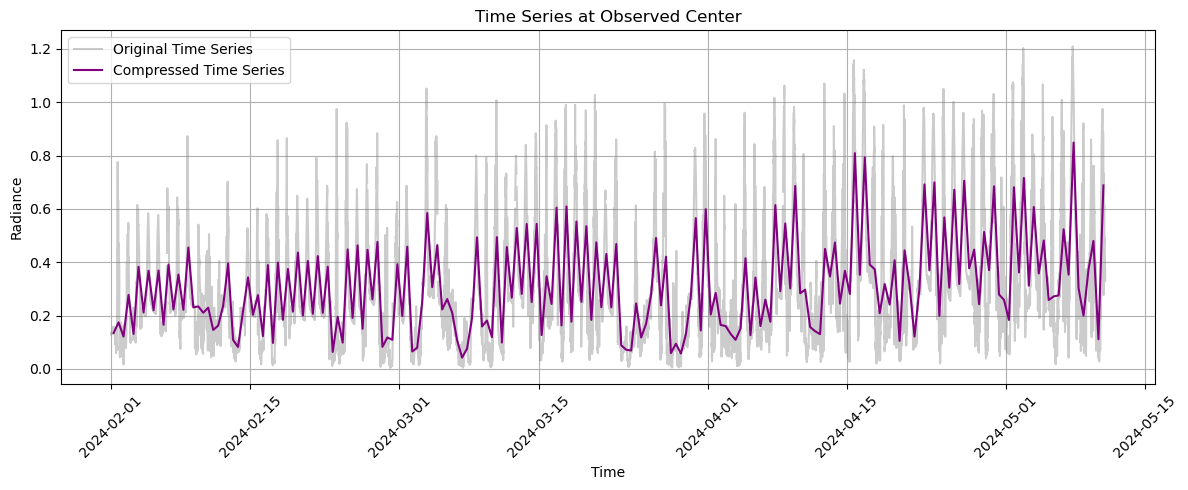

Block 0: 72 frames
Block 1: 72 frames
Block 2: 72 frames
Block 3: 72 frames
Block 4: 72 frames
Block 5: 72 frames
Block 6: 72 frames
Block 7: 72 frames
Block 8: 72 frames
Block 9: 72 frames
Block 10: 72 frames
Block 11: 72 frames
Block 12: 72 frames
Block 13: 72 frames
Block 14: 72 frames
Block 15: 72 frames
Block 16: 72 frames
Block 17: 72 frames
Block 18: 72 frames
Block 19: 72 frames
Block 20: 72 frames
Block 21: 72 frames
Block 22: 72 frames
Block 23: 72 frames
Block 24: 72 frames
Block 25: 72 frames
Block 26: 72 frames
Block 27: 72 frames
Block 28: 72 frames
Block 29: 72 frames
Block 30: 72 frames
Block 31: 72 frames
Block 32: 72 frames
Block 33: 72 frames
Block 34: 72 frames
Block 35: 72 frames
Block 36: 72 frames
Block 37: 72 frames
Block 38: 72 frames
Block 39: 72 frames
Block 40: 72 frames
Block 41: 72 frames
Block 42: 72 frames
Block 43: 72 frames
Block 44: 72 frames
Block 45: 72 frames
Block 46: 72 frames
Block 47: 72 frames
Block 48: 72 frames
Block 49: 72 frames
Block 50: 

In [6]:
duration = timedelta(hours=12)
filepath = 'time_series_cleaned_bos/C07_time_series.nc' #Put filepath here


data, initial_times = load_nc_timeseries(filepath)
frames, times = interpolate_and_trim_frames(data, initial_times, duration, max_gap=timedelta(minutes=12))
N, H, W = frames.shape
compressed_frames, blocks, masks, y, phi, x, g, forward_compressed_frames, block_times, merged_block_times = compress_frames_by_time(frames, times, duration=duration, p=0.5)
plot_center_pixel_time_series(frames, compressed_frames, masks=masks, times_compressed=block_times, times_original=times)

#Quick check to make all blocks have the same number of frames
for i, block in enumerate(blocks):
    print(f"Block {i}: {block.shape[0]} frames")

## Process and Compress all time series

In [12]:
def process_and_save_compressed_blocks(filepath, output_dir,location, band, duration=timedelta(hours=12), frame_spacing=timedelta(minutes=10), max_gap=timedelta(minutes=11.5), p=0.5):
    os.makedirs(output_dir, exist_ok=True)
    data, initial_times = load_nc_timeseries(filepath)
    print(f"Starting compression for {filepath}")
    print(f"Loaded {data.shape[0]} frames")
    print(f"First time: {initial_times[0]}, Last time: {initial_times[-1]}")

    # Check gaps
    gaps = np.diff(initial_times)
    print(f"Largest time gap: {max(gaps)}")
    print(f"Smallest time gap: {min(gaps)}")

    # Optional: show where the big gap is
    for i, g in enumerate(gaps):
        if g > timedelta(hours=2):
            print(f"Large gap at index {i}: {g} between {initial_times[i]} and {initial_times[i+1]}")


    frames, times = interpolate_and_trim_frames(data, initial_times, duration, frame_spacing=frame_spacing, max_gap=max_gap)

    print(f"Interpolated to {frames.shape[0]} frames")
    T, H, W = frames.shape
    print(f"Got {frames.shape[0]} frames after interpolation")

    #Compress frames:    
    compressed_frames, blocks, masks, y_list, phi_list, x_list, g_list, forward_compressed_frames, block_times, merged_block_times = compress_frames_by_time(frames, times, duration=duration, p=0.5)

    for i, (y, phi, x) in enumerate(zip(y_list, masks, blocks)):
        compressed_frame = y.reshape(H, W)
        save_path = os.path.join(output_dir, f"{location}_band_{band:02d}_block_{i:04d}.npz")
        np.savez_compressed(save_path, y=compressed_frame, phi=phi, x=x)

    return len(y_list), output_dir

#Produce compression for multiple bands across multiple locations
def process_multiple_locations_and_bands(base_path, locations, bands, save_root, duration=timedelta(hours=12), frame_spacing=timedelta(minutes=10), max_gap=timedelta(minutes=12), p=0.5):
    summary = []

    for loc in locations:
        for band in bands:
            filename = f"C{band:02d}_time_series.nc"
            filepath = os.path.join(base_path, f'time_series_cleaned_{loc}', filename)
            output_dir = os.path.join(save_root, f'band_{band:02d}')
            os.makedirs(output_dir, exist_ok=True)
            print(f"RAM usage: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")

            try:
                count, path = process_and_save_compressed_blocks(
                    filepath, output_dir,loc, band,
                    duration=duration, frame_spacing=frame_spacing, max_gap=max_gap, p=p)
                summary.append((loc, band, count))
                print(f"Saved {count} blocks for {loc}, band {band:02d}")
            except Exception as e:
                print(f"Skipped {loc}, band {band:02d} due to error: {e}")
                summary.append((loc, band, 0))

    return summary
    
    

In [13]:
#Run function here

locations = ["la2"]
bands = range(1, 17)
base_path = "."
save_root = "data_blocks2_12hours"

summary = process_multiple_locations_and_bands(base_path, locations, bands, save_root)


RAM usage: 1190.16 MB
Starting compression for ./time_series_cleaned_la2/C01_time_series.nc
Loaded 14327 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:10:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:10:00 between 2024-10-02 11:50:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10891: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13389: 3:10:00 between 2024-12-03 07:00:20 and 2024-12-03 10:10:20
→ Interpolated to 14311 frames
Got 14311 frames after interpolation


Compressing Time-Based Blocks: 0it [00:00, ?it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames


Compressing Time-Based Blocks: 216it [00:00, 1594.74it/s]

Compressing block 3 with 72 frames
Compressing block 4 with 72 frames


Compressing Time-Based Blocks: 432it [00:00, 1596.13it/s]

Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames


Compressing Time-Based Blocks: 648it [00:00, 1599.38it/s]

Compressing block 8 with 72 frames
Compressing block 9 with 72 frames


Compressing Time-Based Blocks: 864it [00:00, 1591.77it/s]

Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames


Compressing Time-Based Blocks: 1080it [00:00, 1560.51it/s]

Compressing block 15 with 72 frames
Compressing block 16 with 72 frames


Compressing Time-Based Blocks: 1296it [00:00, 1486.47it/s]

Compressing block 17 with 72 frames
Compressing block 18 with 72 frames


Compressing Time-Based Blocks: 1512it [00:00, 1489.36it/s]

Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames


Compressing Time-Based Blocks: 1728it [00:01, 1483.99it/s]

Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames


Compressing Time-Based Blocks: 1944it [00:01, 1529.64it/s]

Compressing block 27 with 72 frames
Compressing block 28 with 72 frames


Compressing Time-Based Blocks: 2160it [00:01, 1557.35it/s]

Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames


Compressing Time-Based Blocks: 2376it [00:01, 1573.22it/s]

Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames


Compressing Time-Based Blocks: 2592it [00:01, 1500.74it/s]

Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames


Compressing Time-Based Blocks: 2808it [00:01, 1504.65it/s]

Compressing block 39 with 72 frames
Compressing block 40 with 72 frames


Compressing Time-Based Blocks: 3024it [00:01, 1543.50it/s]

Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames


Compressing Time-Based Blocks: 3240it [00:02, 1495.76it/s]

Compressing block 44 with 72 frames
Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3456it [00:02, 1529.94it/s]

Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames


Compressing Time-Based Blocks: 3672it [00:02, 1565.84it/s]

Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames


Compressing Time-Based Blocks: 3888it [00:02, 1582.43it/s]

Compressing block 54 with 72 frames
Compressing block 55 with 72 frames


Compressing Time-Based Blocks: 4104it [00:02, 1505.36it/s]

Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames


Compressing Time-Based Blocks: 4320it [00:02, 1466.32it/s]

Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 70 frames


Compressing Time-Based Blocks: 4534it [00:02, 1493.89it/s]

Compressing block 63 with 72 frames
Compressing block 64 with 72 frames


Compressing Time-Based Blocks: 4750it [00:03, 1536.57it/s]

Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames


Compressing Time-Based Blocks: 4965it [00:03, 1483.49it/s]

Compressing block 68 with 72 frames
Compressing block 69 with 72 frames


Compressing Time-Based Blocks: 5181it [00:03, 1513.73it/s]

Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames


Compressing Time-Based Blocks: 5397it [00:03, 1527.02it/s]

Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames


Compressing Time-Based Blocks: 5613it [00:03, 1501.44it/s]

Compressing block 78 with 72 frames
Compressing block 79 with 72 frames


Compressing Time-Based Blocks: 5829it [00:03, 1528.72it/s]

Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames


Compressing Time-Based Blocks: 6045it [00:03, 1535.05it/s]

Compressing block 83 with 72 frames
Compressing block 84 with 72 frames


Compressing Time-Based Blocks: 6261it [00:04, 1552.00it/s]

Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames


Compressing Time-Based Blocks: 6477it [00:04, 1568.32it/s]

Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames


Compressing Time-Based Blocks: 6693it [00:04, 1574.14it/s]

Compressing block 93 with 72 frames
Compressing block 94 with 72 frames


Compressing Time-Based Blocks: 6909it [00:04, 1581.49it/s]

Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames


Compressing Time-Based Blocks: 7125it [00:04, 1592.48it/s]

Compressing block 98 with 72 frames
Compressing block 99 with 72 frames


Compressing Time-Based Blocks: 7341it [00:04, 1603.33it/s]

Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 7557it [00:04, 1614.64it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames


Compressing Time-Based Blocks: 7773it [00:05, 1620.80it/s]

Compressing block 108 with 72 frames
Compressing block 109 with 72 frames


Compressing Time-Based Blocks: 7989it [00:05, 1626.57it/s]

Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames


Compressing Time-Based Blocks: 8205it [00:05, 1624.47it/s]

Compressing block 113 with 72 frames
Compressing block 114 with 72 frames


Compressing Time-Based Blocks: 8421it [00:05, 1628.44it/s]

Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames


Compressing Time-Based Blocks: 8637it [00:05, 1626.21it/s]

Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames


Compressing Time-Based Blocks: 8853it [00:05, 1637.66it/s]

Compressing block 123 with 72 frames
Compressing block 124 with 72 frames


Compressing Time-Based Blocks: 9069it [00:05, 1649.55it/s]

Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames


Compressing Time-Based Blocks: 9285it [00:05, 1643.80it/s]

Compressing block 128 with 72 frames
Compressing block 129 with 72 frames


Compressing Time-Based Blocks: 9501it [00:06, 1644.21it/s]

Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames


Compressing Time-Based Blocks: 9717it [00:06, 1637.76it/s]

Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames


Compressing Time-Based Blocks: 9933it [00:06, 1642.08it/s]

Compressing block 138 with 72 frames
Compressing block 139 with 72 frames


Compressing Time-Based Blocks: 10149it [00:06, 1634.94it/s]

Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames


Compressing Time-Based Blocks: 10365it [00:06, 1636.36it/s]

Compressing block 143 with 72 frames
Compressing block 144 with 72 frames


Compressing Time-Based Blocks: 10581it [00:06, 1632.98it/s]

Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames


Compressing Time-Based Blocks: 10797it [00:06, 1643.56it/s]

Compressing block 150 with 71 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames


Compressing Time-Based Blocks: 11012it [00:07, 1643.79it/s]

Compressing block 153 with 72 frames
Compressing block 154 with 72 frames


Compressing Time-Based Blocks: 11228it [00:07, 1646.00it/s]

Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames


Compressing Time-Based Blocks: 11444it [00:07, 1640.73it/s]

Compressing block 158 with 72 frames
Compressing block 159 with 72 frames


Compressing Time-Based Blocks: 11660it [00:07, 1635.52it/s]

Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames


Compressing Time-Based Blocks: 11876it [00:07, 1627.50it/s]

Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames


Compressing Time-Based Blocks: 12092it [00:07, 1624.96it/s]

Compressing block 168 with 72 frames
Compressing block 169 with 72 frames


Compressing Time-Based Blocks: 12308it [00:07, 1626.29it/s]

Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames


Compressing Time-Based Blocks: 12524it [00:07, 1623.53it/s]

Compressing block 173 with 72 frames
Compressing block 174 with 72 frames


Compressing Time-Based Blocks: 12740it [00:08, 1625.38it/s]

Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames


Compressing Time-Based Blocks: 12956it [00:08, 1624.99it/s]

Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames


Compressing Time-Based Blocks: 13172it [00:08, 1622.44it/s]

Compressing block 183 with 72 frames
Compressing block 184 with 72 frames


Compressing Time-Based Blocks: 13377it [00:08, 1625.25it/s]

Compressing block 185 with 61 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames


Compressing Time-Based Blocks: 13593it [00:08, 1396.03it/s]

Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames


Compressing Time-Based Blocks: 13807it [00:08, 1465.78it/s]

Compressing block 192 with 72 frames
Compressing block 193 with 72 frames


Compressing Time-Based Blocks: 14023it [00:08, 1507.79it/s]

Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames


Compressing Time-Based Blocks: 14239it [00:09, 1548.53it/s]

Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Compressing Time-Based Blocks: 14311it [00:09, 1572.22it/s]


Saved 199 blocks for la2, band 01
RAM usage: 722.52 MB
Starting compression for ./time_series_cleaned_la2/C02_time_series.nc
Loaded 14324 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:10:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:10:00 between 2024-10-02 11:50:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10891: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13385: 2:50:00 between 2024-12-03 07:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14313 frames
Got 14313 frames after interpolation


Compressing Time-Based Blocks: 72it [00:00, 383.48it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames


Compressing Time-Based Blocks: 216it [00:00, 401.86it/s]

Compressing block 2 with 72 frames
Compressing block 3 with 72 frames


Compressing Time-Based Blocks: 360it [00:00, 411.66it/s]

Compressing block 4 with 72 frames
Compressing block 5 with 72 frames


Compressing Time-Based Blocks: 504it [00:01, 419.69it/s]

Compressing block 6 with 72 frames
Compressing block 7 with 72 frames


Compressing Time-Based Blocks: 648it [00:01, 420.69it/s]

Compressing block 8 with 72 frames
Compressing block 9 with 72 frames


Compressing Time-Based Blocks: 792it [00:01, 430.14it/s]

Compressing block 10 with 72 frames
Compressing block 11 with 72 frames


Compressing Time-Based Blocks: 936it [00:02, 438.45it/s]

Compressing block 12 with 72 frames
Compressing block 13 with 72 frames


Compressing Time-Based Blocks: 1080it [00:02, 430.98it/s]

Compressing block 14 with 72 frames
Compressing block 15 with 72 frames


Compressing Time-Based Blocks: 1224it [00:02, 436.50it/s]

Compressing block 16 with 72 frames
Compressing block 17 with 72 frames


Compressing Time-Based Blocks: 1368it [00:03, 443.04it/s]

Compressing block 18 with 72 frames
Compressing block 19 with 72 frames


Compressing Time-Based Blocks: 1512it [00:03, 443.39it/s]

Compressing block 20 with 72 frames
Compressing block 21 with 72 frames


Compressing Time-Based Blocks: 1656it [00:03, 440.75it/s]

Compressing block 22 with 72 frames
Compressing block 23 with 72 frames


Compressing Time-Based Blocks: 1800it [00:04, 440.41it/s]

Compressing block 24 with 72 frames
Compressing block 25 with 72 frames


Compressing Time-Based Blocks: 1944it [00:04, 439.66it/s]

Compressing block 26 with 72 frames
Compressing block 27 with 72 frames


Compressing Time-Based Blocks: 2088it [00:04, 432.57it/s]

Compressing block 28 with 72 frames
Compressing block 29 with 72 frames


Compressing Time-Based Blocks: 2232it [00:05, 428.24it/s]

Compressing block 30 with 72 frames
Compressing block 31 with 72 frames


Compressing Time-Based Blocks: 2376it [00:05, 427.74it/s]

Compressing block 32 with 72 frames
Compressing block 33 with 72 frames


Compressing Time-Based Blocks: 2520it [00:05, 431.85it/s]

Compressing block 34 with 72 frames
Compressing block 35 with 72 frames


Compressing Time-Based Blocks: 2664it [00:06, 425.07it/s]

Compressing block 36 with 72 frames
Compressing block 37 with 72 frames


Compressing Time-Based Blocks: 2808it [00:06, 422.28it/s]

Compressing block 38 with 72 frames
Compressing block 39 with 72 frames


Compressing Time-Based Blocks: 2952it [00:06, 421.15it/s]

Compressing block 40 with 72 frames
Compressing block 41 with 72 frames


Compressing Time-Based Blocks: 3096it [00:07, 412.15it/s]

Compressing block 42 with 72 frames
Compressing block 43 with 72 frames


Compressing Time-Based Blocks: 3240it [00:07, 418.38it/s]

Compressing block 44 with 72 frames
Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3384it [00:07, 416.26it/s]

Compressing block 46 with 72 frames
Compressing block 47 with 72 frames


Compressing Time-Based Blocks: 3528it [00:08, 416.23it/s]

Compressing block 48 with 72 frames
Compressing block 49 with 72 frames


Compressing Time-Based Blocks: 3672it [00:08, 403.86it/s]

Compressing block 50 with 72 frames
Compressing block 51 with 72 frames


Compressing Time-Based Blocks: 3816it [00:08, 406.31it/s]

Compressing block 52 with 72 frames
Compressing block 53 with 72 frames


Compressing Time-Based Blocks: 3960it [00:09, 405.62it/s]

Compressing block 54 with 72 frames
Compressing block 55 with 72 frames


Compressing Time-Based Blocks: 4104it [00:09, 414.65it/s]

Compressing block 56 with 72 frames
Compressing block 57 with 72 frames


Compressing Time-Based Blocks: 4176it [00:09, 416.55it/s]

Compressing block 58 with 72 frames


Compressing Time-Based Blocks: 4320it [00:10, 359.26it/s]

Compressing block 59 with 72 frames
Compressing block 60 with 72 frames


Compressing Time-Based Blocks: 4464it [00:10, 385.25it/s]

Compressing block 61 with 72 frames
Compressing block 62 with 70 frames


Compressing Time-Based Blocks: 4606it [00:11, 396.30it/s]

Compressing block 63 with 72 frames
Compressing block 64 with 72 frames


Compressing Time-Based Blocks: 4750it [00:11, 392.42it/s]

Compressing block 65 with 72 frames
Compressing block 66 with 71 frames


Compressing Time-Based Blocks: 4893it [00:11, 406.75it/s]

Compressing block 67 with 72 frames
Compressing block 68 with 72 frames


Compressing Time-Based Blocks: 5037it [00:12, 422.05it/s]

Compressing block 69 with 72 frames
Compressing block 70 with 72 frames


Compressing Time-Based Blocks: 5181it [00:12, 422.05it/s]

Compressing block 71 with 72 frames
Compressing block 72 with 72 frames


Compressing Time-Based Blocks: 5325it [00:12, 423.55it/s]

Compressing block 73 with 72 frames
Compressing block 74 with 72 frames


Compressing Time-Based Blocks: 5469it [00:13, 417.47it/s]

Compressing block 75 with 72 frames
Compressing block 76 with 72 frames


Compressing Time-Based Blocks: 5541it [00:13, 387.11it/s]

Compressing block 77 with 72 frames


Compressing Time-Based Blocks: 5613it [00:13, 308.40it/s]

Compressing block 78 with 72 frames


Compressing Time-Based Blocks: 5685it [00:13, 268.41it/s]

Compressing block 79 with 72 frames


Compressing Time-Based Blocks: 5757it [00:14, 278.51it/s]

Compressing block 80 with 72 frames


Compressing Time-Based Blocks: 5829it [00:14, 286.46it/s]

Compressing block 81 with 72 frames


Compressing Time-Based Blocks: 5901it [00:14, 275.02it/s]

Compressing block 82 with 72 frames


Compressing Time-Based Blocks: 5973it [00:15, 277.60it/s]

Compressing block 83 with 72 frames


Compressing Time-Based Blocks: 6117it [00:15, 316.50it/s]

Compressing block 84 with 72 frames
Compressing block 85 with 72 frames


Compressing Time-Based Blocks: 6261it [00:15, 356.37it/s]

Compressing block 86 with 72 frames
Compressing block 87 with 72 frames


Compressing Time-Based Blocks: 6405it [00:16, 372.02it/s]

Compressing block 88 with 72 frames
Compressing block 89 with 72 frames


Compressing Time-Based Blocks: 6549it [00:16, 377.79it/s]

Compressing block 90 with 72 frames
Compressing block 91 with 72 frames


Compressing Time-Based Blocks: 6621it [00:16, 302.18it/s]

Compressing block 92 with 72 frames


Compressing Time-Based Blocks: 6693it [00:17, 263.26it/s]

Compressing block 93 with 72 frames


Compressing Time-Based Blocks: 6765it [00:17, 268.61it/s]

Compressing block 94 with 72 frames


Compressing Time-Based Blocks: 6837it [00:17, 256.02it/s]

Compressing block 95 with 72 frames


Compressing Time-Based Blocks: 6909it [00:17, 278.53it/s]

Compressing block 96 with 72 frames


Compressing Time-Based Blocks: 7053it [00:18, 316.26it/s]

Compressing block 97 with 72 frames
Compressing block 98 with 72 frames


Compressing Time-Based Blocks: 7197it [00:18, 362.63it/s]

Compressing block 99 with 72 frames
Compressing block 100 with 72 frames


Compressing Time-Based Blocks: 7341it [00:19, 372.23it/s]

Compressing block 101 with 72 frames
Compressing block 102 with 72 frames


Compressing Time-Based Blocks: 7485it [00:19, 390.52it/s]

Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 7629it [00:19, 400.45it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames


Compressing Time-Based Blocks: 7773it [00:20, 401.79it/s]

Compressing block 107 with 72 frames
Compressing block 108 with 72 frames


Compressing Time-Based Blocks: 7917it [00:20, 403.44it/s]

Compressing block 109 with 72 frames
Compressing block 110 with 72 frames


Compressing Time-Based Blocks: 8061it [00:20, 410.51it/s]

Compressing block 111 with 72 frames
Compressing block 112 with 72 frames


Compressing Time-Based Blocks: 8205it [00:21, 413.05it/s]

Compressing block 113 with 72 frames
Compressing block 114 with 72 frames


Compressing Time-Based Blocks: 8349it [00:21, 412.68it/s]

Compressing block 115 with 72 frames
Compressing block 116 with 72 frames


Compressing Time-Based Blocks: 8493it [00:21, 418.75it/s]

Compressing block 117 with 72 frames
Compressing block 118 with 72 frames


Compressing Time-Based Blocks: 8637it [00:22, 429.15it/s]

Compressing block 119 with 72 frames
Compressing block 120 with 72 frames


Compressing Time-Based Blocks: 8781it [00:22, 427.27it/s]

Compressing block 121 with 72 frames
Compressing block 122 with 72 frames


Compressing Time-Based Blocks: 8925it [00:22, 427.97it/s]

Compressing block 123 with 72 frames
Compressing block 124 with 72 frames


Compressing Time-Based Blocks: 9069it [00:23, 428.81it/s]

Compressing block 125 with 72 frames
Compressing block 126 with 72 frames


Compressing Time-Based Blocks: 9213it [00:23, 425.51it/s]

Compressing block 127 with 72 frames
Compressing block 128 with 72 frames


Compressing Time-Based Blocks: 9357it [00:23, 415.87it/s]

Compressing block 129 with 72 frames
Compressing block 130 with 72 frames


Compressing Time-Based Blocks: 9501it [00:24, 418.37it/s]

Compressing block 131 with 72 frames
Compressing block 132 with 72 frames


Compressing Time-Based Blocks: 9645it [00:24, 412.83it/s]

Compressing block 133 with 72 frames
Compressing block 134 with 72 frames


Compressing Time-Based Blocks: 9789it [00:24, 417.30it/s]

Compressing block 135 with 72 frames
Compressing block 136 with 72 frames


Compressing Time-Based Blocks: 9933it [00:25, 417.27it/s]

Compressing block 137 with 72 frames
Compressing block 138 with 72 frames


Compressing Time-Based Blocks: 10077it [00:25, 408.02it/s]

Compressing block 139 with 72 frames
Compressing block 140 with 72 frames


Compressing Time-Based Blocks: 10221it [00:26, 417.23it/s]

Compressing block 141 with 72 frames
Compressing block 142 with 72 frames


Compressing Time-Based Blocks: 10365it [00:26, 409.97it/s]

Compressing block 143 with 72 frames
Compressing block 144 with 72 frames


Compressing Time-Based Blocks: 10509it [00:26, 398.07it/s]

Compressing block 145 with 72 frames
Compressing block 146 with 72 frames


Compressing Time-Based Blocks: 10653it [00:27, 402.82it/s]

Compressing block 147 with 72 frames
Compressing block 148 with 72 frames


Compressing Time-Based Blocks: 10797it [00:27, 407.40it/s]

Compressing block 149 with 72 frames
Compressing block 150 with 71 frames


Compressing Time-Based Blocks: 10940it [00:27, 407.02it/s]

Compressing block 151 with 72 frames
Compressing block 152 with 72 frames


Compressing Time-Based Blocks: 11084it [00:28, 413.82it/s]

Compressing block 153 with 72 frames
Compressing block 154 with 72 frames


Compressing Time-Based Blocks: 11228it [00:28, 412.36it/s]

Compressing block 155 with 72 frames
Compressing block 156 with 72 frames


Compressing Time-Based Blocks: 11300it [00:28, 394.53it/s]

Compressing block 157 with 72 frames


Compressing Time-Based Blocks: 11444it [00:29, 379.91it/s]

Compressing block 158 with 72 frames
Compressing block 159 with 72 frames


Compressing Time-Based Blocks: 11516it [00:29, 388.88it/s]

Compressing block 160 with 72 frames


Compressing Time-Based Blocks: 11660it [00:29, 384.20it/s]

Compressing block 161 with 72 frames
Compressing block 162 with 72 frames


Compressing Time-Based Blocks: 11804it [00:30, 401.71it/s]

Compressing block 163 with 72 frames
Compressing block 164 with 72 frames


Compressing Time-Based Blocks: 11948it [00:30, 403.96it/s]

Compressing block 165 with 72 frames
Compressing block 166 with 72 frames


Compressing Time-Based Blocks: 12092it [00:30, 408.86it/s]

Compressing block 167 with 72 frames
Compressing block 168 with 72 frames


Compressing Time-Based Blocks: 12236it [00:31, 404.23it/s]

Compressing block 169 with 72 frames
Compressing block 170 with 72 frames


Compressing Time-Based Blocks: 12380it [00:31, 410.43it/s]

Compressing block 171 with 72 frames
Compressing block 172 with 72 frames


Compressing Time-Based Blocks: 12524it [00:31, 414.49it/s]

Compressing block 173 with 72 frames
Compressing block 174 with 72 frames


Compressing Time-Based Blocks: 12668it [00:32, 416.05it/s]

Compressing block 175 with 72 frames
Compressing block 176 with 72 frames


Compressing Time-Based Blocks: 12812it [00:32, 416.30it/s]

Compressing block 177 with 72 frames
Compressing block 178 with 72 frames


Compressing Time-Based Blocks: 12956it [00:32, 414.15it/s]

Compressing block 179 with 72 frames
Compressing block 180 with 72 frames


Compressing Time-Based Blocks: 13100it [00:33, 393.20it/s]

Compressing block 181 with 72 frames
Compressing block 182 with 72 frames


Compressing Time-Based Blocks: 13244it [00:33, 386.51it/s]

Compressing block 183 with 72 frames
Compressing block 184 with 72 frames


Compressing Time-Based Blocks: 13379it [00:33, 393.62it/s]

Compressing block 185 with 63 frames
Compressing block 186 with 72 frames


Compressing Time-Based Blocks: 13523it [00:34, 387.08it/s]

Compressing block 187 with 72 frames
Compressing block 188 with 72 frames


Compressing Time-Based Blocks: 13667it [00:34, 392.09it/s]

Compressing block 189 with 72 frames
Compressing block 190 with 72 frames


Compressing Time-Based Blocks: 13809it [00:34, 403.39it/s]

Compressing block 191 with 70 frames
Compressing block 192 with 72 frames


Compressing Time-Based Blocks: 13953it [00:35, 410.58it/s]

Compressing block 193 with 72 frames
Compressing block 194 with 72 frames


Compressing Time-Based Blocks: 14097it [00:35, 418.83it/s]

Compressing block 195 with 72 frames
Compressing block 196 with 72 frames


Compressing Time-Based Blocks: 14241it [00:36, 400.35it/s]

Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Compressing Time-Based Blocks: 14313it [00:36, 395.03it/s]


Saved 199 blocks for la2, band 02
RAM usage: 197.00 MB
Starting compression for ./time_series_cleaned_la2/C03_time_series.nc
Loaded 14325 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10891: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 11132: 2:30:00 between 2024-11-17 12:40:20 and 2024-11-17 15:10:20
⚠️ Large gap at index 13387: 3:00:00 between 2024-12-03 07:10:20 and 2024-12-03 10:10:20
⚠️ Large time gap: 2:30:00 at index 24
→ Interpolated to 14311 frames
Got 14311 frames after interpolation


Compressing Time-Based Blocks: 0it [00:00, ?it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames


Compressing Time-Based Blocks: 144it [00:00, 755.97it/s]

Compressing block 2 with 72 frames


Compressing Time-Based Blocks: 288it [00:00, 960.25it/s]

Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames


Compressing Time-Based Blocks: 504it [00:00, 1182.85it/s]

Compressing block 6 with 72 frames
Compressing block 7 with 72 frames


Compressing Time-Based Blocks: 648it [00:00, 1248.29it/s]

Compressing block 8 with 72 frames
Compressing block 9 with 72 frames


Compressing Time-Based Blocks: 864it [00:00, 1320.54it/s]

Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames


Compressing Time-Based Blocks: 1080it [00:00, 1397.55it/s]

Compressing block 15 with 72 frames
Compressing block 16 with 72 frames


Compressing Time-Based Blocks: 1296it [00:00, 1437.13it/s]

Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames


Compressing Time-Based Blocks: 1512it [00:01, 1473.14it/s]

Compressing block 20 with 72 frames
Compressing block 21 with 72 frames


Compressing Time-Based Blocks: 1728it [00:01, 1499.48it/s]

Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames


Compressing Time-Based Blocks: 1944it [00:01, 1412.41it/s]

Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames


Compressing Time-Based Blocks: 2160it [00:01, 1458.33it/s]

Compressing block 30 with 72 frames


Compressing Time-Based Blocks: 2376it [00:01, 1491.83it/s]

Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames


Compressing Time-Based Blocks: 2808it [00:02, 1513.60it/s]

Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames


Compressing Time-Based Blocks: 3024it [00:02, 1520.91it/s]

Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames


Compressing Time-Based Blocks: 3240it [00:02, 1547.01it/s]

Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3456it [00:02, 1552.53it/s]

Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames


Compressing Time-Based Blocks: 3888it [00:02, 1574.18it/s]

Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames


Compressing Time-Based Blocks: 4104it [00:02, 1579.00it/s]

Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames


Compressing Time-Based Blocks: 4320it [00:02, 1596.58it/s]

Compressing block 60 with 72 frames


Compressing Time-Based Blocks: 4533it [00:03, 1530.47it/s]

Compressing block 61 with 72 frames
Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames


Compressing Time-Based Blocks: 4749it [00:03, 1512.79it/s]

Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames


Compressing Time-Based Blocks: 4964it [00:03, 1454.90it/s]

Compressing block 69 with 72 frames


Compressing Time-Based Blocks: 5180it [00:03, 1440.21it/s]

Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames


Compressing Time-Based Blocks: 5396it [00:03, 1452.51it/s]

Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames


Compressing Time-Based Blocks: 5612it [00:03, 1465.36it/s]

Compressing block 78 with 72 frames


Compressing Time-Based Blocks: 5828it [00:04, 1475.46it/s]

Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames


Compressing Time-Based Blocks: 6188it [00:04, 1411.30it/s]

Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames


Compressing Time-Based Blocks: 6548it [00:04, 1415.05it/s]

Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames


Compressing Time-Based Blocks: 6764it [00:04, 1470.29it/s]

Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames


Compressing Time-Based Blocks: 6980it [00:04, 1502.23it/s]

Compressing block 97 with 72 frames


Compressing Time-Based Blocks: 7196it [00:04, 1525.23it/s]

Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames


Compressing Time-Based Blocks: 7628it [00:05, 1583.57it/s]

Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames


Compressing Time-Based Blocks: 7844it [00:05, 1595.79it/s]

Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames


Compressing Time-Based Blocks: 8060it [00:05, 1597.89it/s]

Compressing block 112 with 72 frames


Compressing Time-Based Blocks: 8276it [00:05, 1578.45it/s]

Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames


Compressing Time-Based Blocks: 8708it [00:05, 1597.66it/s]

Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames


Compressing Time-Based Blocks: 8924it [00:06, 1612.07it/s]

Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames


Compressing Time-Based Blocks: 9140it [00:06, 1635.38it/s]

Compressing block 127 with 72 frames


Compressing Time-Based Blocks: 9356it [00:06, 1647.53it/s]

Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames


Compressing Time-Based Blocks: 9788it [00:06, 1654.77it/s]

Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames


Compressing Time-Based Blocks: 10004it [00:06, 1654.89it/s]

Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames


Compressing Time-Based Blocks: 10436it [00:06, 1570.31it/s]

Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames


Compressing Time-Based Blocks: 10867it [00:07, 1621.77it/s]

Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames


Compressing Time-Based Blocks: 11083it [00:07, 1648.14it/s]

Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames


Compressing Time-Based Blocks: 11515it [00:07, 1664.99it/s]

Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames


Compressing Time-Based Blocks: 11947it [00:07, 1670.21it/s]

Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames


Compressing Time-Based Blocks: 12163it [00:08, 1582.29it/s]

Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames


Compressing Time-Based Blocks: 12595it [00:08, 1603.60it/s]

Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames


Compressing Time-Based Blocks: 13027it [00:08, 1647.72it/s]

Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames


Compressing Time-Based Blocks: 13243it [00:08, 1651.78it/s]

Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 62 frames
Compressing block 186 with 72 frames


Compressing Time-Based Blocks: 13665it [00:08, 1652.96it/s]

Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames


Compressing Time-Based Blocks: 14095it [00:09, 1583.23it/s]

Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames


Compressing Time-Based Blocks: 14311it [00:09, 1533.70it/s]


Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Saved 199 blocks for la2, band 03
RAM usage: 1530.59 MB
Starting compression for ./time_series_cleaned_la2/C04_time_series.nc
Loaded 14300 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:50:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4554: 4:30:00 between 2024-10-02 11:30:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10877: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13363: 4:50:00 between 2024-12-03 05:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14299 frames
Got 14299 frames after interpolation


Compressing Time-Based Blocks: 432it [00:00, 4037.26it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames


Compressing Time-Based Blocks: 1296it [00:00, 4011.27it/s]

Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames


Compressing Time-Based Blocks: 2160it [00:00, 4056.76it/s]

Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames


Compressing Time-Based Blocks: 3024it [00:00, 4031.29it/s]

Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3888it [00:00, 3971.40it/s]

Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames


Compressing Time-Based Blocks: 4748it [00:01, 3968.90it/s]

Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 68 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames


Compressing Time-Based Blocks: 5611it [00:01, 4038.95it/s]

Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames


Compressing Time-Based Blocks: 6475it [00:01, 4020.99it/s]

Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames


Compressing Time-Based Blocks: 7339it [00:01, 4043.17it/s]

Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 8275it [00:02, 4236.69it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames


Compressing Time-Based Blocks: 9139it [00:02, 4211.06it/s]

Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames


Compressing Time-Based Blocks: 10003it [00:02, 4224.28it/s]

Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames


Compressing Time-Based Blocks: 10866it [00:02, 4219.25it/s]

Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames


Compressing Time-Based Blocks: 11730it [00:02, 4223.18it/s]

Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames


Compressing Time-Based Blocks: 12594it [00:03, 4212.51it/s]

Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames


Compressing Time-Based Blocks: 13509it [00:03, 4230.01it/s]

Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 51 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames


Compressing Time-Based Blocks: 14299it [00:03, 4125.87it/s]


Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Saved 199 blocks for la2, band 04
RAM usage: 1922.02 MB
Starting compression for ./time_series_cleaned_la2/C05_time_series.nc
Loaded 14322 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:30:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4553: 4:30:00 between 2024-10-02 11:30:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10888: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13384: 3:30:00 between 2024-12-03 06:40:20 and 2024-12-03 10:10:20
→ Interpolated to 14307 frames
Got 14307 frames after interpolation


Compressing Time-Based Blocks: 144it [00:00, 1283.46it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames


Compressing Time-Based Blocks: 432it [00:00, 1264.88it/s]

Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames


Compressing Time-Based Blocks: 648it [00:00, 1360.30it/s]

Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames


Compressing Time-Based Blocks: 792it [00:00, 1354.47it/s]

Compressing block 11 with 72 frames


Compressing Time-Based Blocks: 936it [00:00, 1352.79it/s]

Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames


Compressing Time-Based Blocks: 1152it [00:00, 1421.03it/s]

Compressing block 16 with 72 frames


Compressing Time-Based Blocks: 1368it [00:00, 1443.88it/s]

Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames


Compressing Time-Based Blocks: 1800it [00:01, 1518.71it/s]

Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames


Compressing Time-Based Blocks: 2016it [00:01, 1546.10it/s]

Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames


Compressing Time-Based Blocks: 2232it [00:01, 1569.07it/s]

Compressing block 31 with 72 frames


Compressing Time-Based Blocks: 2448it [00:01, 1574.34it/s]

Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames


Compressing Time-Based Blocks: 2664it [00:01, 1583.33it/s]

Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames


Compressing Time-Based Blocks: 2880it [00:01, 1432.23it/s]

Compressing block 40 with 72 frames


Compressing Time-Based Blocks: 3096it [00:02, 1449.65it/s]

Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3528it [00:02, 1535.82it/s]

Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames


Compressing Time-Based Blocks: 3744it [00:02, 1562.40it/s]

Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames


Compressing Time-Based Blocks: 3960it [00:02, 1598.11it/s]

Compressing block 55 with 72 frames


Compressing Time-Based Blocks: 4176it [00:02, 1632.48it/s]

Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames


Compressing Time-Based Blocks: 4604it [00:03, 1645.98it/s]

Compressing block 61 with 72 frames
Compressing block 62 with 68 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames


Compressing Time-Based Blocks: 4819it [00:03, 1646.75it/s]

Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames


Compressing Time-Based Blocks: 5035it [00:03, 1639.98it/s]

Compressing block 70 with 72 frames


Compressing Time-Based Blocks: 5251it [00:03, 1658.63it/s]

Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames


Compressing Time-Based Blocks: 5683it [00:03, 1649.80it/s]

Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames


Compressing Time-Based Blocks: 5899it [00:03, 1653.57it/s]

Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames


Compressing Time-Based Blocks: 6115it [00:03, 1678.63it/s]

Compressing block 85 with 72 frames


Compressing Time-Based Blocks: 6331it [00:04, 1509.53it/s]

Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames


Compressing Time-Based Blocks: 6547it [00:04, 1515.14it/s]

Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames


Compressing Time-Based Blocks: 6763it [00:04, 1526.35it/s]

Compressing block 94 with 72 frames


Compressing Time-Based Blocks: 6979it [00:04, 1560.92it/s]

Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames


Compressing Time-Based Blocks: 7411it [00:04, 1608.30it/s]

Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 7627it [00:04, 1621.75it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames


Compressing Time-Based Blocks: 7843it [00:05, 1612.54it/s]

Compressing block 109 with 72 frames


Compressing Time-Based Blocks: 8059it [00:05, 1635.67it/s]

Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames


Compressing Time-Based Blocks: 8491it [00:05, 1652.34it/s]

Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames


Compressing Time-Based Blocks: 8707it [00:05, 1657.12it/s]

Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames


Compressing Time-Based Blocks: 8923it [00:05, 1674.59it/s]

Compressing block 124 with 72 frames


Compressing Time-Based Blocks: 9139it [00:05, 1674.76it/s]

Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames


Compressing Time-Based Blocks: 9571it [00:06, 1681.30it/s]

Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames


Compressing Time-Based Blocks: 9787it [00:06, 1694.79it/s]

Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames


Compressing Time-Based Blocks: 10003it [00:06, 1701.69it/s]

Compressing block 139 with 72 frames


Compressing Time-Based Blocks: 10219it [00:06, 1715.79it/s]

Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames


Compressing Time-Based Blocks: 10651it [00:06, 1670.14it/s]

Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames


Compressing Time-Based Blocks: 10866it [00:06, 1658.15it/s]

Compressing block 150 with 71 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames


Compressing Time-Based Blocks: 11082it [00:06, 1649.86it/s]

Compressing block 154 with 72 frames


Compressing Time-Based Blocks: 11298it [00:07, 1641.37it/s]

Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames


Compressing Time-Based Blocks: 11730it [00:07, 1640.93it/s]

Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames


Compressing Time-Based Blocks: 11946it [00:07, 1638.37it/s]

Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames


Compressing Time-Based Blocks: 12162it [00:07, 1631.74it/s]

Compressing block 169 with 72 frames


Compressing Time-Based Blocks: 12378it [00:07, 1636.66it/s]

Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames


Compressing Time-Based Blocks: 12810it [00:08, 1643.66it/s]

Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames


Compressing Time-Based Blocks: 13026it [00:08, 1663.61it/s]

Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames


Compressing Time-Based Blocks: 13242it [00:08, 1630.72it/s]

Compressing block 184 with 72 frames


Compressing Time-Based Blocks: 13445it [00:08, 1593.32it/s]

Compressing block 185 with 59 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames


Compressing Time-Based Blocks: 13875it [00:08, 1574.60it/s]

Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames


Compressing Time-Based Blocks: 14091it [00:08, 1600.68it/s]

Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Compressing Time-Based Blocks: 14307it [00:08, 1591.25it/s]


Saved 199 blocks for la2, band 05
RAM usage: 1088.62 MB
Starting compression for ./time_series_cleaned_la2/C06_time_series.nc
Loaded 14299 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:30:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4555: 4:30:00 between 2024-10-02 11:30:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10878: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13362: 3:10:00 between 2024-12-03 07:00:20 and 2024-12-03 10:10:20
→ Interpolated to 14309 frames
Got 14309 frames after interpolation


Compressing Time-Based Blocks: 504it [00:00, 4570.81it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames
Compressing block 13 with 72 frames


Compressing Time-Based Blocks: 1512it [00:00, 4711.17it/s]

Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames


Compressing Time-Based Blocks: 2520it [00:00, 4672.85it/s]

Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames


Compressing Time-Based Blocks: 3528it [00:00, 4684.51it/s]

Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames


Compressing Time-Based Blocks: 4532it [00:00, 4753.09it/s]

Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 68 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames


Compressing Time-Based Blocks: 5539it [00:01, 4706.78it/s]

Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames


Compressing Time-Based Blocks: 6547it [00:01, 4662.71it/s]

Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames


Compressing Time-Based Blocks: 7051it [00:01, 4643.80it/s]

Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 7555it [00:01, 4645.60it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames


Compressing Time-Based Blocks: 8059it [00:01, 4652.15it/s]

Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames


Compressing Time-Based Blocks: 8563it [00:01, 4675.85it/s]

Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames


Compressing Time-Based Blocks: 9067it [00:01, 4692.99it/s]

Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames


Compressing Time-Based Blocks: 9571it [00:02, 4752.91it/s]

Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames


Compressing Time-Based Blocks: 10075it [00:02, 4746.86it/s]

Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames


Compressing Time-Based Blocks: 10579it [00:02, 4753.60it/s]

Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames


Compressing Time-Based Blocks: 11082it [00:02, 4746.12it/s]

Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames


Compressing Time-Based Blocks: 11586it [00:02, 4754.85it/s]

Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames


Compressing Time-Based Blocks: 12090it [00:02, 4778.58it/s]

Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames


Compressing Time-Based Blocks: 12666it [00:02, 4884.46it/s]

Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames


Compressing Time-Based Blocks: 13242it [00:02, 4931.19it/s]

Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 61 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames


Compressing Time-Based Blocks: 13735it [00:02, 4889.48it/s]

Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames


Compressing Time-Based Blocks: 14309it [00:03, 4744.02it/s]

Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 06
RAM usage: 1811.69 MB
Starting compression for ./time_series_cleaned_la2/C07_time_series.nc
Loaded 14301 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4554: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10876: 3:00:00 between 2024-11-15 17:30:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13364: 2:50:00 between 2024-12-03 07:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14311 frames
Got 14311 frames after interpolation


Compressing Time-Based Blocks: 504it [00:00, 4512.37it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames


Compressing Time-Based Blocks: 1512it [00:00, 4600.10it/s]

Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames


Compressing Time-Based Blocks: 2520it [00:00, 4562.87it/s]

Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames


Compressing Time-Based Blocks: 3024it [00:00, 4608.99it/s]

Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3960it [00:00, 3556.10it/s]

Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames


Compressing Time-Based Blocks: 4964it [00:01, 3975.18it/s]

Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames


Compressing Time-Based Blocks: 5468it [00:01, 4153.04it/s]

Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames


Compressing Time-Based Blocks: 5972it [00:01, 4285.79it/s]

Compressing block 83 with 72 frames


Compressing Time-Based Blocks: 6476it [00:01, 4369.51it/s]

Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames


Compressing Time-Based Blocks: 7484it [00:01, 4463.38it/s]

Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames


Compressing Time-Based Blocks: 8492it [00:02, 4429.64it/s]

Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames


Compressing Time-Based Blocks: 9500it [00:02, 4544.23it/s]

Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames


Compressing Time-Based Blocks: 10508it [00:02, 4557.51it/s]

Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames


Compressing Time-Based Blocks: 11514it [00:02, 4584.47it/s]

Compressing block 150 with 70 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames


Compressing Time-Based Blocks: 12522it [00:02, 4574.67it/s]

Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames


Compressing Time-Based Blocks: 13521it [00:03, 4615.40it/s]

Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 63 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames


Compressing Time-Based Blocks: 14311it [00:03, 4379.48it/s]


Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Saved 199 blocks for la2, band 07
RAM usage: 2260.81 MB
Starting compression for ./time_series_cleaned_la2/C08_time_series.nc
Loaded 14297 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4554: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10875: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 11114: 2:20:00 between 2024-11-17 12:50:20 and 2024-11-17 15:10:20
⚠️ Large gap at index 13360: 3:10:00 between 2024-12-03 07:00:20 and 2024-12-03 10:10:20
⚠️ Large time gap: 2:20:00 at index 25
→ Interpol

Compressing Time-Based Blocks: 504it [00:00, 4401.85it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames


Compressing Time-Based Blocks: 1440it [00:00, 4034.89it/s]

Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames


Compressing Time-Based Blocks: 2376it [00:00, 4185.06it/s]

Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames


Compressing Time-Based Blocks: 2808it [00:00, 4215.95it/s]

Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames


Compressing Time-Based Blocks: 3312it [00:00, 3994.55it/s]

Compressing block 46 with 72 frames


Compressing Time-Based Blocks: 3744it [00:00, 3958.47it/s]

Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames


Compressing Time-Based Blocks: 4677it [00:01, 3932.60it/s]

Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames


Compressing Time-Based Blocks: 5612it [00:01, 4175.92it/s]

Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames


Compressing Time-Based Blocks: 6476it [00:01, 4175.89it/s]

Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames


Compressing Time-Based Blocks: 7484it [00:01, 4410.53it/s]

Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames


Compressing Time-Based Blocks: 8420it [00:02, 4281.64it/s]

Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames


Compressing Time-Based Blocks: 9428it [00:02, 4500.74it/s]

Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames


Compressing Time-Based Blocks: 10436it [00:02, 4650.40it/s]

Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames


Compressing Time-Based Blocks: 11443it [00:02, 4734.30it/s]

Compressing block 150 with 71 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames


Compressing Time-Based Blocks: 12451it [00:02, 4682.36it/s]

Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames


Compressing Time-Based Blocks: 13448it [00:03, 4666.52it/s]

Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 61 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames


Compressing Time-Based Blocks: 14310it [00:03, 4345.65it/s]


Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Saved 199 blocks for la2, band 08
RAM usage: 2217.02 MB
Starting compression for ./time_series_cleaned_la2/C09_time_series.nc
Loaded 14304 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10878: 3:00:00 between 2024-11-15 17:30:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13367: 2:50:00 between 2024-12-03 07:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14311 frames
Got 14311 frames after interpolation


Compressing Time-Based Blocks: 504it [00:00, 4568.69it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames


Compressing Time-Based Blocks: 1512it [00:00, 4507.56it/s]

Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames


Compressing Time-Based Blocks: 2520it [00:00, 4497.00it/s]

Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames


Compressing Time-Based Blocks: 3528it [00:00, 4447.12it/s]

Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames


Compressing Time-Based Blocks: 4032it [00:00, 4491.45it/s]

Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 69 frames


Compressing Time-Based Blocks: 4533it [00:01, 4493.82it/s]

Compressing block 63 with 72 frames
Compressing block 64 with 72 frames


Compressing Time-Based Blocks: 5036it [00:01, 4519.15it/s]

Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames


Compressing Time-Based Blocks: 5540it [00:01, 4555.50it/s]

Compressing block 76 with 72 frames
Compressing block 77 with 72 frames


Compressing Time-Based Blocks: 6044it [00:01, 4537.00it/s]

Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames


Compressing Time-Based Blocks: 7052it [00:01, 4582.08it/s]

Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 8060it [00:01, 4610.85it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames


Compressing Time-Based Blocks: 9068it [00:01, 4606.63it/s]

Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames


Compressing Time-Based Blocks: 10076it [00:02, 4654.94it/s]

Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames


Compressing Time-Based Blocks: 10580it [00:02, 4644.90it/s]

Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 70 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames


Compressing Time-Based Blocks: 11082it [00:02, 4633.45it/s]

Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames


Compressing Time-Based Blocks: 11586it [00:02, 4637.64it/s]

Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames


Compressing Time-Based Blocks: 12090it [00:02, 4661.59it/s]

Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames


Compressing Time-Based Blocks: 12594it [00:02, 4665.73it/s]

Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames


Compressing Time-Based Blocks: 13098it [00:02, 4661.62it/s]

Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 63 frames
Compressing block 186 with 72 frames


Compressing Time-Based Blocks: 13593it [00:02, 4620.28it/s]

Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames


Compressing Time-Based Blocks: 14311it [00:03, 4581.92it/s]

Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 09
RAM usage: 2370.27 MB
Starting compression for ./time_series_cleaned_la2/C10_time_series.nc
Loaded 14299 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4555: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10877: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 11116: 2:10:00 between 2024-11-17 13:00:20 and 2024-11-17 15:10:20
⚠️ Large gap at index 13362: 2:50:00 between 2024-12-03 07:20:20 and 2024-12-03 10:10:20
⚠️ Large time gap: 2:10:00 at index 26
→ Interpolated to 14312 frames
Got 14312 frames after interpolation


Compressing Time-Based Blocks: 504it [00:00, 4358.66it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames


Compressing Time-Based Blocks: 1512it [00:00, 4351.44it/s]

Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames


Compressing Time-Based Blocks: 2016it [00:00, 4388.98it/s]

Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames


Compressing Time-Based Blocks: 2520it [00:00, 4428.38it/s]

Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames


Compressing Time-Based Blocks: 3024it [00:00, 4479.95it/s]

Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames


Compressing Time-Based Blocks: 3528it [00:00, 4515.49it/s]

Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames


Compressing Time-Based Blocks: 4032it [00:00, 4531.16it/s]

Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames


Compressing Time-Based Blocks: 4533it [00:01, 4599.03it/s]

Compressing block 61 with 72 frames
Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames


Compressing Time-Based Blocks: 5036it [00:01, 4651.55it/s]

Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames


Compressing Time-Based Blocks: 5540it [00:01, 4657.37it/s]

Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames


Compressing Time-Based Blocks: 6044it [00:01, 4584.21it/s]

Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames


Compressing Time-Based Blocks: 6548it [00:01, 4555.83it/s]

Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames


Compressing Time-Based Blocks: 7052it [00:01, 4533.92it/s]

Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames


Compressing Time-Based Blocks: 7556it [00:01, 4552.03it/s]

Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames


Compressing Time-Based Blocks: 8060it [00:01, 4593.76it/s]

Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames


Compressing Time-Based Blocks: 8564it [00:01, 4617.26it/s]

Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames


Compressing Time-Based Blocks: 9068it [00:01, 4622.59it/s]

Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames


Compressing Time-Based Blocks: 10076it [00:02, 4635.04it/s]

Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames


Compressing Time-Based Blocks: 11083it [00:02, 4680.17it/s]

Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames


Compressing Time-Based Blocks: 12091it [00:02, 4730.05it/s]

Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames


Compressing Time-Based Blocks: 12595it [00:02, 4034.99it/s]

Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames


Compressing Time-Based Blocks: 13099it [00:02, 4187.86it/s]

Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames


Compressing Time-Based Blocks: 13594it [00:03, 4199.69it/s]

Compressing block 184 with 72 frames
Compressing block 185 with 63 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames


Compressing Time-Based Blocks: 14096it [00:03, 4320.36it/s]

Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames


Compressing Time-Based Blocks: 14312it [00:03, 4493.44it/s]


Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Saved 199 blocks for la2, band 10
RAM usage: 1890.64 MB
Starting compression for ./time_series_cleaned_la2/C11_time_series.nc
Loaded 14305 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4555: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10878: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13368: 2:50:00 between 2024-12-03 07:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14312 frames
Got 14312 frames after interpolation


Compressing Time-Based Blocks: 432it [00:00, 4117.50it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames


Compressing Time-Based Blocks: 1296it [00:00, 4256.18it/s]

Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames


Compressing Time-Based Blocks: 2160it [00:00, 4241.38it/s]

Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames


Compressing Time-Based Blocks: 3096it [00:00, 4280.18it/s]

Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames


Compressing Time-Based Blocks: 4104it [00:00, 4316.86it/s]

Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames


Compressing Time-Based Blocks: 5180it [00:01, 4587.35it/s]

Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames


Compressing Time-Based Blocks: 5756it [00:01, 4736.47it/s]

Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames


Compressing Time-Based Blocks: 6332it [00:01, 4817.82it/s]

Compressing block 88 with 72 frames
Compressing block 89 with 72 frames


Compressing Time-Based Blocks: 6836it [00:01, 4638.67it/s]

Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames


Compressing Time-Based Blocks: 7340it [00:01, 4564.51it/s]

Compressing block 101 with 72 frames
Compressing block 102 with 72 frames


Compressing Time-Based Blocks: 7844it [00:01, 4490.97it/s]

Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames


Compressing Time-Based Blocks: 8852it [00:01, 4459.80it/s]

Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames


Compressing Time-Based Blocks: 9860it [00:02, 4086.09it/s]

Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames


Compressing Time-Based Blocks: 10796it [00:02, 4238.87it/s]

Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames


Compressing Time-Based Blocks: 11803it [00:02, 4523.17it/s]

Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames


Compressing Time-Based Blocks: 12307it [00:02, 4549.07it/s]

Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames


Compressing Time-Based Blocks: 13315it [00:03, 4263.52it/s]

Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 63 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames


Compressing Time-Based Blocks: 14312it [00:03, 4405.87it/s]

Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 11
RAM usage: 2009.22 MB
Starting compression for ./time_series_cleaned_la2/C12_time_series.nc
Loaded 14304 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:50:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:30:00 between 2024-10-02 11:30:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10879: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13367: 4:50:00 between 2024-12-03 05:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14299 frames
Got 14299 frames after interpolation


Compressing Time-Based Blocks: 504it [00:00, 4448.80it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames


Compressing Time-Based Blocks: 1512it [00:00, 4295.83it/s]

Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames


Compressing Time-Based Blocks: 2376it [00:00, 4104.54it/s]

Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames


Compressing Time-Based Blocks: 3240it [00:00, 4172.63it/s]

Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames


Compressing Time-Based Blocks: 3744it [00:00, 4243.34it/s]

Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames


Compressing Time-Based Blocks: 4176it [00:00, 4195.32it/s]

Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames


Compressing Time-Based Blocks: 4676it [00:01, 4237.16it/s]

Compressing block 61 with 72 frames
Compressing block 62 with 68 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames


Compressing Time-Based Blocks: 5539it [00:01, 3979.39it/s]

Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames


Compressing Time-Based Blocks: 6547it [00:01, 4220.25it/s]

Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames


Compressing Time-Based Blocks: 7555it [00:01, 4335.50it/s]

Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames


Compressing Time-Based Blocks: 8563it [00:02, 4410.19it/s]

Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames


Compressing Time-Based Blocks: 9571it [00:02, 4597.36it/s]

Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames


Compressing Time-Based Blocks: 10579it [00:02, 4708.42it/s]

Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames


Compressing Time-Based Blocks: 11586it [00:02, 4709.96it/s]

Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames


Compressing Time-Based Blocks: 12090it [00:02, 4612.08it/s]

Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames


Compressing Time-Based Blocks: 12594it [00:02, 4592.22it/s]

Compressing block 175 with 72 frames
Compressing block 176 with 72 frames


Compressing Time-Based Blocks: 13098it [00:02, 4547.72it/s]

Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 51 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames


Compressing Time-Based Blocks: 13581it [00:03, 4489.98it/s]

Compressing block 188 with 72 frames
Compressing block 189 with 72 frames


Compressing Time-Based Blocks: 14299it [00:03, 4367.56it/s]

Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 12
RAM usage: 2030.94 MB
Starting compression for ./time_series_cleaned_la2/C13_time_series.nc
Loaded 14295 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10879: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 11112: 4:00:00 between 2024-11-17 11:10:20 and 2024-11-17 15:10:20
⚠️ Large gap at index 13358: 3:00:00 between 2024-12-03 07:10:20 and 2024-12-03 10:10:20
⚠️ Large time gap: 4:00:00 at index 15
→ Interpolated to 14311 frames
Got 14311 frames after interpolation


Compressing Time-Based Blocks: 360it [00:00, 3485.10it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames


Compressing Time-Based Blocks: 1224it [00:00, 3773.50it/s]

Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames


Compressing Time-Based Blocks: 2088it [00:00, 3869.70it/s]

Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames


Compressing Time-Based Blocks: 2520it [00:00, 3709.80it/s]

Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames


Compressing Time-Based Blocks: 2952it [00:00, 3614.91it/s]

Compressing block 41 with 72 frames
Compressing block 42 with 72 frames


Compressing Time-Based Blocks: 3384it [00:00, 3483.03it/s]

Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames


Compressing Time-Based Blocks: 3816it [00:01, 3601.43it/s]

Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames


Compressing Time-Based Blocks: 4248it [00:01, 3676.50it/s]

Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames


Compressing Time-Based Blocks: 4677it [00:01, 3839.11it/s]

Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames


Compressing Time-Based Blocks: 5180it [00:01, 4053.57it/s]

Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames


Compressing Time-Based Blocks: 5684it [00:01, 4290.75it/s]

Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames


Compressing Time-Based Blocks: 6188it [00:01, 4263.03it/s]

Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames


Compressing Time-Based Blocks: 6620it [00:01, 4120.47it/s]

Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames


Compressing Time-Based Blocks: 7124it [00:01, 4202.79it/s]

Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames


Compressing Time-Based Blocks: 7628it [00:01, 4294.36it/s]

Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames


Compressing Time-Based Blocks: 8132it [00:02, 4389.20it/s]

Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames


Compressing Time-Based Blocks: 8636it [00:02, 4409.07it/s]

Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames


Compressing Time-Based Blocks: 9140it [00:02, 4445.16it/s]

Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames


Compressing Time-Based Blocks: 9644it [00:02, 4484.63it/s]

Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames


Compressing Time-Based Blocks: 10148it [00:02, 4550.56it/s]

Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames


Compressing Time-Based Blocks: 10652it [00:02, 4577.51it/s]

Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames


Compressing Time-Based Blocks: 11155it [00:02, 4586.27it/s]

Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames


Compressing Time-Based Blocks: 11659it [00:02, 4534.74it/s]

Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames


Compressing Time-Based Blocks: 12163it [00:02, 4586.90it/s]

Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames


Compressing Time-Based Blocks: 12667it [00:03, 4645.52it/s]

Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames


Compressing Time-Based Blocks: 13171it [00:03, 4691.15it/s]

Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 62 frames


Compressing Time-Based Blocks: 13665it [00:03, 4752.19it/s]

Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames


Compressing Time-Based Blocks: 14311it [00:03, 4261.72it/s]

Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 13
RAM usage: 1872.98 MB
Starting compression for ./time_series_cleaned_la2/C14_time_series.nc
Loaded 14304 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4556: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10878: 3:00:00 between 2024-11-15 17:30:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 11120: 2:10:00 between 2024-11-17 13:00:20 and 2024-11-17 15:10:20
⚠️ Large gap at index 13367: 3:00:00 between 2024-12-03 07:10:20 and 2024-12-03 10:10:20
⚠️ Large time gap: 2:10:00 at index 26
→ Interpolated to 14310 frames
Got 14310 frames after interpolation


Compressing Time-Based Blocks: 432it [00:00, 4266.25it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames


Compressing Time-Based Blocks: 936it [00:00, 4275.06it/s]

Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames


Compressing Time-Based Blocks: 1800it [00:00, 3198.58it/s]

Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames


Compressing Time-Based Blocks: 2736it [00:00, 3548.50it/s]

Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames


Compressing Time-Based Blocks: 3240it [00:00, 3778.47it/s]

Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames
Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames


Compressing Time-Based Blocks: 3744it [00:01, 4012.92it/s]

Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames


Compressing Time-Based Blocks: 4176it [00:01, 3859.00it/s]

Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames
Compressing block 62 with 69 frames


Compressing Time-Based Blocks: 4605it [00:01, 3965.13it/s]

Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames


Compressing Time-Based Blocks: 5036it [00:01, 3996.93it/s]

Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames


Compressing Time-Based Blocks: 5468it [00:01, 4071.69it/s]

Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames


Compressing Time-Based Blocks: 5972it [00:01, 4227.37it/s]

Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames


Compressing Time-Based Blocks: 6476it [00:01, 4288.07it/s]

Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames


Compressing Time-Based Blocks: 6980it [00:01, 4380.45it/s]

Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames


Compressing Time-Based Blocks: 7988it [00:02, 4102.15it/s]

Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames


Compressing Time-Based Blocks: 8420it [00:02, 4125.05it/s]

Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames


Compressing Time-Based Blocks: 8852it [00:02, 3686.15it/s]

Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames


Compressing Time-Based Blocks: 9284it [00:02, 2979.05it/s]

Compressing block 129 with 72 frames
Compressing block 130 with 72 frames


Compressing Time-Based Blocks: 9716it [00:02, 3262.71it/s]

Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames


Compressing Time-Based Blocks: 10148it [00:02, 3467.46it/s]

Compressing block 141 with 72 frames
Compressing block 142 with 72 frames


Compressing Time-Based Blocks: 10652it [00:02, 3749.18it/s]

Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 70 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames


Compressing Time-Based Blocks: 11154it [00:02, 3928.01it/s]

Compressing block 154 with 72 frames
Compressing block 155 with 72 frames


Compressing Time-Based Blocks: 11658it [00:03, 4112.27it/s]

Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames


Compressing Time-Based Blocks: 12162it [00:03, 4288.83it/s]

Compressing block 168 with 72 frames


Compressing Time-Based Blocks: 12666it [00:03, 4237.42it/s]

Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames
Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames


Compressing Time-Based Blocks: 13520it [00:03, 3809.29it/s]

Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 62 frames
Compressing block 186 with 72 frames
Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames


Compressing Time-Based Blocks: 14310it [00:03, 3852.35it/s]


Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames
Saved 199 blocks for la2, band 14
RAM usage: 2133.98 MB
Starting compression for ./time_series_cleaned_la2/C15_time_series.nc
Loaded 14304 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4555: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10878: 2:50:00 between 2024-11-15 17:40:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 13367: 2:50:00 between 2024-12-03 07:20:20 and 2024-12-03 10:10:20
→ Interpolated to 14312 frames
Got 14312 frames after interpolation


Compressing Time-Based Blocks: 432it [00:00, 4267.00it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames
Compressing block 11 with 72 frames
Compressing block 12 with 72 frames


Compressing Time-Based Blocks: 1440it [00:00, 4286.20it/s]

Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames
Compressing block 23 with 72 frames
Compressing block 24 with 72 frames


Compressing Time-Based Blocks: 2376it [00:00, 4221.76it/s]

Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames
Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames
Compressing block 36 with 72 frames


Compressing Time-Based Blocks: 3240it [00:00, 4194.59it/s]

Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames
Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames


Compressing Time-Based Blocks: 3744it [00:00, 4276.30it/s]

Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames
Compressing block 58 with 72 frames


Compressing Time-Based Blocks: 4248it [00:00, 4322.33it/s]

Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames


Compressing Time-Based Blocks: 4749it [00:01, 4129.00it/s]

Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames


Compressing Time-Based Blocks: 5180it [00:01, 4135.25it/s]

Compressing block 70 with 72 frames
Compressing block 71 with 72 frames
Compressing block 72 with 72 frames


Compressing Time-Based Blocks: 5684it [00:01, 4199.97it/s]

Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames
Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames
Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames


Compressing Time-Based Blocks: 6692it [00:01, 4296.50it/s]

Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames
Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames
Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames


Compressing Time-Based Blocks: 7628it [00:01, 4362.96it/s]

Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames
Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames
Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames


Compressing Time-Based Blocks: 8636it [00:02, 4311.04it/s]

Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames
Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames
Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames


Compressing Time-Based Blocks: 9140it [00:02, 4336.80it/s]

Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames
Compressing block 133 with 72 frames


Compressing Time-Based Blocks: 9644it [00:02, 4385.93it/s]

Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames


Compressing Time-Based Blocks: 10148it [00:02, 3276.05it/s]

Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames
Compressing block 146 with 72 frames
Compressing block 147 with 72 frames


Compressing Time-Based Blocks: 10652it [00:02, 3578.29it/s]

Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 71 frames
Compressing block 151 with 72 frames


Compressing Time-Based Blocks: 11155it [00:02, 3798.85it/s]

Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames
Compressing block 160 with 72 frames


Compressing Time-Based Blocks: 11659it [00:02, 3962.84it/s]

Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames


Compressing Time-Based Blocks: 12163it [00:02, 4103.36it/s]

Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames


Compressing Time-Based Blocks: 12667it [00:03, 4220.92it/s]

Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames


Compressing Time-Based Blocks: 13171it [00:03, 4317.42it/s]

Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 63 frames
Compressing block 186 with 72 frames


Compressing Time-Based Blocks: 13666it [00:03, 4361.49it/s]

Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames


Compressing Time-Based Blocks: 14312it [00:03, 4175.34it/s]

Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames
Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 15
RAM usage: 1419.42 MB
Starting compression for ./time_series_cleaned_la2/C16_time_series.nc
Loaded 14297 frames
First time: 2024-09-01 00:00:20, Last time: 2024-12-09 23:50:20
Largest time gap: 4:20:00
Smallest time gap: 0:00:00
⚠️ Large gap at index 4555: 4:20:00 between 2024-10-02 11:40:20 and 2024-10-02 16:00:20
⚠️ Large gap at index 10876: 3:00:00 between 2024-11-15 17:30:19 and 2024-11-15 20:30:19
⚠️ Large gap at index 11114: 2:20:00 between 2024-11-17 12:50:20 and 2024-11-17 15:10:20
⚠️ Large gap at index 13360: 3:00:00 between 2024-12-03 07:10:20 and 2024-12-03 10:10:20
⚠️ Large time gap: 2:20:00 at index 25
→ Interpolated to 14310 frames
Got 14310 frames after interpolation


Compressing Time-Based Blocks: 432it [00:00, 3624.86it/s]

Compressing block 0 with 72 frames
Compressing block 1 with 72 frames
Compressing block 2 with 72 frames
Compressing block 3 with 72 frames
Compressing block 4 with 72 frames
Compressing block 5 with 72 frames
Compressing block 6 with 72 frames
Compressing block 7 with 72 frames
Compressing block 8 with 72 frames
Compressing block 9 with 72 frames
Compressing block 10 with 72 frames


Compressing Time-Based Blocks: 1296it [00:00, 3868.35it/s]

Compressing block 11 with 72 frames
Compressing block 12 with 72 frames
Compressing block 13 with 72 frames
Compressing block 14 with 72 frames
Compressing block 15 with 72 frames
Compressing block 16 with 72 frames
Compressing block 17 with 72 frames
Compressing block 18 with 72 frames
Compressing block 19 with 72 frames
Compressing block 20 with 72 frames
Compressing block 21 with 72 frames
Compressing block 22 with 72 frames


Compressing Time-Based Blocks: 1728it [00:00, 3529.01it/s]

Compressing block 23 with 72 frames
Compressing block 24 with 72 frames
Compressing block 25 with 72 frames
Compressing block 26 with 72 frames
Compressing block 27 with 72 frames
Compressing block 28 with 72 frames
Compressing block 29 with 72 frames
Compressing block 30 with 72 frames


Compressing Time-Based Blocks: 2232it [00:00, 3915.35it/s]

Compressing block 31 with 72 frames
Compressing block 32 with 72 frames
Compressing block 33 with 72 frames
Compressing block 34 with 72 frames
Compressing block 35 with 72 frames


Compressing Time-Based Blocks: 2736it [00:00, 4167.90it/s]

Compressing block 36 with 72 frames
Compressing block 37 with 72 frames
Compressing block 38 with 72 frames
Compressing block 39 with 72 frames
Compressing block 40 with 72 frames
Compressing block 41 with 72 frames
Compressing block 42 with 72 frames
Compressing block 43 with 72 frames


Compressing Time-Based Blocks: 3240it [00:00, 4275.86it/s]

Compressing block 44 with 72 frames
Compressing block 45 with 72 frames
Compressing block 46 with 72 frames
Compressing block 47 with 72 frames
Compressing block 48 with 72 frames


Compressing Time-Based Blocks: 3744it [00:00, 4399.80it/s]

Compressing block 49 with 72 frames
Compressing block 50 with 72 frames
Compressing block 51 with 72 frames
Compressing block 52 with 72 frames
Compressing block 53 with 72 frames
Compressing block 54 with 72 frames
Compressing block 55 with 72 frames
Compressing block 56 with 72 frames
Compressing block 57 with 72 frames


Compressing Time-Based Blocks: 4248it [00:01, 4504.48it/s]

Compressing block 58 with 72 frames
Compressing block 59 with 72 frames
Compressing block 60 with 72 frames
Compressing block 61 with 72 frames


Compressing Time-Based Blocks: 4749it [00:01, 4289.19it/s]

Compressing block 62 with 69 frames
Compressing block 63 with 72 frames
Compressing block 64 with 72 frames
Compressing block 65 with 72 frames
Compressing block 66 with 71 frames
Compressing block 67 with 72 frames
Compressing block 68 with 72 frames
Compressing block 69 with 72 frames
Compressing block 70 with 72 frames


Compressing Time-Based Blocks: 5252it [00:01, 3763.41it/s]

Compressing block 71 with 72 frames
Compressing block 72 with 72 frames
Compressing block 73 with 72 frames
Compressing block 74 with 72 frames
Compressing block 75 with 72 frames
Compressing block 76 with 72 frames


Compressing Time-Based Blocks: 5684it [00:01, 3445.29it/s]

Compressing block 77 with 72 frames
Compressing block 78 with 72 frames
Compressing block 79 with 72 frames


Compressing Time-Based Blocks: 6116it [00:01, 3571.01it/s]

Compressing block 80 with 72 frames
Compressing block 81 with 72 frames
Compressing block 82 with 72 frames
Compressing block 83 with 72 frames
Compressing block 84 with 72 frames
Compressing block 85 with 72 frames
Compressing block 86 with 72 frames
Compressing block 87 with 72 frames
Compressing block 88 with 72 frames


Compressing Time-Based Blocks: 6548it [00:01, 3719.81it/s]

Compressing block 89 with 72 frames
Compressing block 90 with 72 frames
Compressing block 91 with 72 frames


Compressing Time-Based Blocks: 7052it [00:01, 3917.82it/s]

Compressing block 92 with 72 frames
Compressing block 93 with 72 frames
Compressing block 94 with 72 frames
Compressing block 95 with 72 frames
Compressing block 96 with 72 frames
Compressing block 97 with 72 frames
Compressing block 98 with 72 frames
Compressing block 99 with 72 frames
Compressing block 100 with 72 frames
Compressing block 101 with 72 frames


Compressing Time-Based Blocks: 7556it [00:01, 4169.99it/s]

Compressing block 102 with 72 frames
Compressing block 103 with 72 frames
Compressing block 104 with 72 frames
Compressing block 105 with 72 frames


Compressing Time-Based Blocks: 8060it [00:02, 4389.20it/s]

Compressing block 106 with 72 frames
Compressing block 107 with 72 frames
Compressing block 108 with 72 frames
Compressing block 109 with 72 frames
Compressing block 110 with 72 frames
Compressing block 111 with 72 frames
Compressing block 112 with 72 frames
Compressing block 113 with 72 frames
Compressing block 114 with 72 frames
Compressing block 115 with 72 frames


Compressing Time-Based Blocks: 8564it [00:02, 4528.20it/s]

Compressing block 116 with 72 frames
Compressing block 117 with 72 frames
Compressing block 118 with 72 frames
Compressing block 119 with 72 frames


Compressing Time-Based Blocks: 9068it [00:02, 4506.60it/s]

Compressing block 120 with 72 frames
Compressing block 121 with 72 frames
Compressing block 122 with 72 frames
Compressing block 123 with 72 frames
Compressing block 124 with 72 frames
Compressing block 125 with 72 frames
Compressing block 126 with 72 frames
Compressing block 127 with 72 frames
Compressing block 128 with 72 frames
Compressing block 129 with 72 frames
Compressing block 130 with 72 frames
Compressing block 131 with 72 frames
Compressing block 132 with 72 frames


Compressing Time-Based Blocks: 10076it [00:02, 4542.90it/s]

Compressing block 133 with 72 frames
Compressing block 134 with 72 frames
Compressing block 135 with 72 frames
Compressing block 136 with 72 frames
Compressing block 137 with 72 frames
Compressing block 138 with 72 frames
Compressing block 139 with 72 frames
Compressing block 140 with 72 frames
Compressing block 141 with 72 frames
Compressing block 142 with 72 frames
Compressing block 143 with 72 frames
Compressing block 144 with 72 frames
Compressing block 145 with 72 frames


Compressing Time-Based Blocks: 11082it [00:02, 4640.73it/s]

Compressing block 146 with 72 frames
Compressing block 147 with 72 frames
Compressing block 148 with 72 frames
Compressing block 149 with 72 frames
Compressing block 150 with 70 frames
Compressing block 151 with 72 frames
Compressing block 152 with 72 frames
Compressing block 153 with 72 frames
Compressing block 154 with 72 frames
Compressing block 155 with 72 frames
Compressing block 156 with 72 frames
Compressing block 157 with 72 frames
Compressing block 158 with 72 frames
Compressing block 159 with 72 frames


Compressing Time-Based Blocks: 12090it [00:02, 4700.94it/s]

Compressing block 160 with 72 frames
Compressing block 161 with 72 frames
Compressing block 162 with 72 frames
Compressing block 163 with 72 frames
Compressing block 164 with 72 frames
Compressing block 165 with 72 frames
Compressing block 166 with 72 frames
Compressing block 167 with 72 frames
Compressing block 168 with 72 frames
Compressing block 169 with 72 frames
Compressing block 170 with 72 frames
Compressing block 171 with 72 frames
Compressing block 172 with 72 frames
Compressing block 173 with 72 frames


Compressing Time-Based Blocks: 13098it [00:03, 4638.71it/s]

Compressing block 174 with 72 frames
Compressing block 175 with 72 frames
Compressing block 176 with 72 frames
Compressing block 177 with 72 frames
Compressing block 178 with 72 frames
Compressing block 179 with 72 frames
Compressing block 180 with 72 frames
Compressing block 181 with 72 frames
Compressing block 182 with 72 frames
Compressing block 183 with 72 frames
Compressing block 184 with 72 frames
Compressing block 185 with 62 frames
Compressing block 186 with 72 frames


Compressing Time-Based Blocks: 13592it [00:03, 4584.96it/s]

Compressing block 187 with 72 frames
Compressing block 188 with 72 frames
Compressing block 189 with 72 frames
Compressing block 190 with 72 frames
Compressing block 191 with 70 frames
Compressing block 192 with 72 frames
Compressing block 193 with 72 frames
Compressing block 194 with 72 frames
Compressing block 195 with 72 frames


Compressing Time-Based Blocks: 14310it [00:03, 4265.20it/s]

Compressing block 196 with 72 frames
Compressing block 197 with 72 frames
Compressing block 198 with 72 frames


Saved 199 blocks for la2, band 16
